# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Data loading](#Data-loading)
* [Models](#Models)
* [Test harness](#Test-harness)
* [Metaclassifier](#Metaclassifier)
* [Results](#Results)
* [Discussion](#Discussion)

# Introduction

In this notebook, the following classifiers are cross validated with untuned hyperparameters:
* LinearDiscrimantAnalysis
* LogisticRegression
* RidgeClassifier
* SGDClassifier
* SVC

5-fold train-test splits with scaling, dimensionality reduction, and resampling have already been preprocessed on the full dataset. The results are visualized and discussed.

# Imports and configuration

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from collections import namedtuple
from gc import collect as gc_collect
from os.path import exists
from tqdm.notebook import tqdm

# typing
from typing import Dict, List

# faster pandas & sklearn
import swifter
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# metrics
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import balanced_accuracy_score, f1_score

# classifiers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import (
    LogisticRegression,
    RidgeClassifier,
    SGDClassifier,
)
from sklearn.svm import SVC

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
sns.set_style("whitegrid")
%matplotlib inline

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

# hide warnings
import warnings

warnings.filterwarnings("ignore")
del warnings

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 6.16 s


In [4]:
# Location of cross validation .feather files
FRILL_FEATHERS_FOLDER = "../10.0-mic-prepare_train-test_splits_on_full_data"

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 120 ms


# Setup

In this section, we define some structures to keep track of models and scores.

The next cell defines a Python dictionary to record the results of cross validation such that the results may be easily cast to a `pandas` dataframe.

In [5]:
METRICS = (
    "balanced_accuracy",
    "f1",
    "geometric_mean",
    "fit_time",
    "predict_time",
)

# to be cast to pd.DataFrame
make_results = lambda: {key: [] for key in {"model_name", "case", *METRICS}}
results_ = make_results()

AvgScores = namedtuple("AvgScores", METRICS)


def store_result(
    where: Dict[str, List],
    case: str,
    model_name: str,
    avg_scores: AvgScores,
) -> None:
    "Appends a model's scores and fit/predict times to the results dict."
    for attribute, value in {
        "model_name": model_name,
        "case": case,
        **avg_scores._asdict(),
    }.items():
        where[attribute].append(value)


ALL_CASES = {"negative", "neutral", "ternary", "ternary_negneu"}

_ = gc_collect()

time: 113 ms


In [6]:
predictions_ = {key: [] for key in {"model", "case", "fold", "y_pred"}}

Prediction = namedtuple("Prediction", predictions_.keys())


def store_prediction(where: Dict[str, List], prediction: Prediction) -> None:
    "Records the y_pred of a classifier on a fold"
    for k, v in prediction._asdict().items():
        where[k].append(v)


_ = gc_collect()

time: 127 ms


# Models

Thanks to FRILL, we may now use the gamut of binary classifiers.

For the most part, the default settings of each classifier are used. Where possible, the seed is set and all available cores are used. Class weight parameters are set to address class imbalance. Each classifier is wrapped in a lambda function to ensure a brand new model is initialized each time the function is called.

In [7]:
MODELS = {
    "Dummy": lambda: DummyClassifier(random_state=SEED),
    "LDA": lambda: LinearDiscriminantAnalysis(),
    "LogReg": lambda: LogisticRegression(
        class_weight="balanced", random_state=SEED, n_jobs=-1
    ),
    "Ridge": lambda: RidgeClassifier(class_weight="balanced", random_state=SEED),
    "SGD": lambda: SGDClassifier(n_jobs=-1, random_state=SEED, class_weight="balanced"),
    "SVC": lambda: SVC(random_state=SEED, class_weight="balanced"),
}

_ = gc_collect()

time: 173 ms


# Test harness

This section defines functions for evaluating models.

In [8]:
def evaluate_model(
    model_base: str, case: str, track_fold_time: bool = True
) -> AvgScores:
    """Evaluate a model with cross validation on prepared folds."""

    fit_times, predict_times, balanced_accuracy, f1, geometric_mean = [], [], [], [], []
    fold_num = 0
    while True:
        if track_fold_time:
            fold_begin = time()

        # helper function
        read_feather_cv = lambda _set: pd.read_feather(
            f"{FRILL_FEATHERS_FOLDER}/cv_{fold_num}/{_set}{'' if _set == 'X_test' else f'_{case[:3]}'}.feather"
        )
        # MinMax -> SparseRandomProjection -> ADASYN -> OneSidedSelection

        # load training data
        try:
            X_train, y_train = read_feather_cv("X_train"), np.squeeze(
                read_feather_cv("y_train").values
            )
        except FileNotFoundError:
            break

        # initialize model
        model = MODELS[model_base]()

        # fit
        begin = time()
        model.fit(X_train, y_train)
        end = time()
        del X_train
        del y_train
        _ = gc_collect()
        fit_times.append(end - begin)
        print(f"fitted in {end - begin:.2f} s")

        # load test data
        X_test = read_feather_cv("X_test")

        # predict
        begin = time()
        predicted = model.predict(X_test)
        end = time()
        del X_test
        del model
        _ = gc_collect()
        predict_times.append(end - begin)
        print(f"predicted in {end - begin:.2f} s")
        del end
        del begin
        _ = gc_collect()
        store_prediction(
            where=predictions_,
            prediction=Prediction(
                model=model_base,
                case=case,
                fold=fold_num,
                y_pred=predicted,
            ),
        )

        # score
        score_params = {
            "y_true": np.squeeze(read_feather_cv("y_test").values),
            "y_pred": predicted,
        }
        balanced_accuracy.append(balanced_accuracy_score(**score_params))
        f1.append(f1_score(**score_params, average="weighted"))
        geometric_mean.append(geometric_mean_score(**score_params))
        del score_params
        del predicted
        _ = gc_collect()

        if track_fold_time:
            print(
                f"{model_base} fold {fold_num + 1} completed in {time() - fold_begin:.2f} s"
            )
            del fold_begin

        fold_num += 1
        _ = gc_collect()

    return AvgScores(
        *[
            np.mean(_)
            for _ in (balanced_accuracy, f1, geometric_mean, fit_times, predict_times)
        ]
    )


_ = gc_collect()

time: 137 ms


The next few cells evaluate models.

In [9]:
case = "negative"
for model in tqdm(MODELS):
    loop_begin = time()
    print(f"evaluating {model}...")
    store_result(
        where=results_,
        case=case,
        model_name=model,
        avg_scores=evaluate_model(model, case),
    )
    print(f"stored {model} for {case} classification in {time() - loop_begin:.2f} s")
    del loop_begin
    _ = gc_collect()

  0%|          | 0/6 [00:00<?, ?it/s]

evaluating Dummy...
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 1 completed in 3.40 s
fitted in 0.01 s
predicted in 0.00 s
Dummy fold 2 completed in 3.14 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 3 completed in 2.78 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 4 completed in 2.80 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 5 completed in 2.95 s
stored Dummy for negative classification in 15.71 s
evaluating LDA...
fitted in 38.02 s
predicted in 0.05 s
LDA fold 1 completed in 39.94 s
fitted in 36.82 s
predicted in 0.05 s
LDA fold 2 completed in 39.49 s
fitted in 31.05 s
predicted in 0.05 s
LDA fold 3 completed in 33.48 s
fitted in 28.18 s
predicted in 0.05 s
LDA fold 4 completed in 30.64 s
fitted in 37.91 s
predicted in 0.03 s
LDA fold 5 completed in 40.42 s
stored LDA for negative classification in 184.55 s
evaluating LogReg...
fitted in 11.11 s
predicted in 0.06 s
LogReg fold 1 completed in 13.81 s
fitted in 10.77 s
predicted in 0.03 s
LogReg fold 2 completed in 

In [10]:
case = "neutral"
for model in tqdm(MODELS):
    loop_begin = time()
    print(f"evaluating {model}...")
    store_result(
        where=results_,
        case=case,
        model_name=model,
        avg_scores=evaluate_model(model, case),
    )
    print(f"stored {model} for {case} classification in {time() - loop_begin:.2f} s")
    del loop_begin
    _ = gc_collect()

  0%|          | 0/6 [00:00<?, ?it/s]

evaluating Dummy...
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 1 completed in 3.30 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 2 completed in 3.35 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 3 completed in 3.87 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 4 completed in 3.45 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 5 completed in 3.62 s
stored Dummy for neutral classification in 18.20 s
evaluating LDA...
fitted in 55.65 s
predicted in 0.04 s
LDA fold 1 completed in 59.37 s
fitted in 55.43 s
predicted in 0.03 s
LDA fold 2 completed in 58.72 s
fitted in 49.41 s
predicted in 0.03 s
LDA fold 3 completed in 52.67 s
fitted in 42.45 s
predicted in 0.05 s
LDA fold 4 completed in 45.48 s
fitted in 49.28 s
predicted in 0.03 s
LDA fold 5 completed in 52.44 s
stored LDA for neutral classification in 269.27 s
evaluating LogReg...
fitted in 16.23 s
predicted in 0.06 s
LogReg fold 1 completed in 19.50 s
fitted in 16.64 s
predicted in 0.03 s
LogReg fold 2 completed in 19

In [11]:
case = "ternary"
for model in tqdm(MODELS):
    loop_begin = time()
    print(f"evaluating {model}...")
    store_result(
        where=results_,
        case=case,
        model_name=model,
        avg_scores=evaluate_model(model, case),
    )
    print(f"stored {model} for {case} classification in {time() - loop_begin:.2f} s")
    del loop_begin
    _ = gc_collect()

  0%|          | 0/6 [00:00<?, ?it/s]

evaluating Dummy...
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 1 completed in 3.43 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 2 completed in 3.52 s
fitted in 0.02 s
predicted in 0.00 s
Dummy fold 3 completed in 3.48 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 4 completed in 3.23 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 5 completed in 3.69 s
stored Dummy for ternary classification in 17.92 s
evaluating LDA...
fitted in 61.83 s
predicted in 0.07 s
LDA fold 1 completed in 65.52 s
fitted in 57.05 s
predicted in 0.03 s
LDA fold 2 completed in 60.63 s
fitted in 53.52 s
predicted in 0.05 s
LDA fold 3 completed in 56.90 s
fitted in 44.18 s
predicted in 0.06 s
LDA fold 4 completed in 47.39 s
fitted in 58.22 s
predicted in 0.06 s
LDA fold 5 completed in 61.59 s
stored LDA for ternary classification in 292.60 s
evaluating LogReg...
fitted in 27.74 s
predicted in 0.26 s
LogReg fold 1 completed in 31.40 s
fitted in 27.96 s
predicted in 0.18 s
LogReg fold 2 completed in 31

Let's peek at the results.

In [12]:
results_df = pd.DataFrame(results_).reset_index(drop=True)
results_df

,model_name,geometric_mean,fit_time,predict_time,f1,case,balanced_accuracy
0,Dummy,0.000000,0.003400,0.000800,0.375599,negative,0.500000
1,LDA,0.643996,34.396286,0.045120,0.653322,negative,0.647329
2,LogReg,0.642722,10.175857,0.046320,0.651208,negative,0.645692
3,Ridge,0.645930,4.753259,0.037116,0.654431,negative,0.648998
4,SGD,0.640984,19.638570,0.038648,0.650131,negative,0.645135
5,SVC,0.666719,317.956529,51.399344,0.679755,negative,0.672735
6,Dummy,0.000000,0.000400,0.000799,0.310113,neutral,0.500000
7,LDA,0.738908,50.441713,0.036673,0.767020,neutral,0.740530
8,LogReg,0.733144,15.453209,0.044446,0.770639,neutral,0.735676
9,Ridge,0.739624,7.696320,0.038642,0.768287,neutral,0.741470


time: 62.2 ms


# Metaclassifier

After the binary classifiers are evaluated, the metaclassifiers are evaluated based on the binary predictions. The metaclassifiers' fit and score times are estimated by summing the fit and score times of the base estimators.

In [13]:
# helper function
get_time = lambda case, model_name, metric: results_df.query(
    f"case == '{case}' & model_name == '{model_name}'"
)[metric].item()

pred_df = pd.DataFrame(predictions_).query(f"case != 'ternary'")
for neutral_model in tqdm(MODELS.keys()):
    for negative_model in MODELS.keys():
        balanced_accuracy, f1, geometric_mean = [], [], []
        model_combo = f"{neutral_model}+{negative_model}"
        fold_num = 0
        while True:
            if not exists(
                ytrue_path := f"{FRILL_FEATHERS_FOLDER}/cv_{fold_num}/y_test_ter.feather"
            ):
                break
            # ensemble
            fold_df = pred_df.query(f"fold == {fold_num}").drop(columns="fold")
            neutral_condition = f"case == 'neutral' & model == '{neutral_model}'"
            negative_condition = f"case == 'negative' & model == '{negative_model}'"
            query_fold = lambda criteria: fold_df.query(criteria).y_pred.item()
            df = pd.DataFrame(
                {
                    "neutral_prediction": query_fold(neutral_condition),
                    "negative_prediction": query_fold(negative_condition),
                }
            )
            del fold_df
            del negative_condition
            del neutral_condition
            del query_fold
            _ = gc_collect()

            # "predict" 0: negative, 1: neutral, 2: positive
            df["hybrid_prediction"] = df.neutral_prediction.replace(True, 1)
            df.loc[df["hybrid_prediction"] == False, "hybrid_prediction"] = df.loc[
                df["hybrid_prediction"] == False, "negative_prediction"
            ].replace([True, False], [0, 2])
            y_pred = df.hybrid_prediction.astype(np.int8)
            del df
            _ = gc_collect()

            # record y_pred
            store_prediction(
                where=predictions_,
                prediction=Prediction(
                    model=model_combo,
                    case="ternary_negneu",
                    fold=fold_num,
                    y_pred=y_pred,
                ),
            )

            # score
            score_params = {
                "y_true": np.squeeze(pd.read_feather(ytrue_path).values),
                "y_pred": y_pred,
            }
            balanced_accuracy.append(balanced_accuracy_score(**score_params))
            f1.append(f1_score(**score_params, average="weighted"))
            geometric_mean.append(geometric_mean_score(**score_params))
            del score_params
            del y_pred
            _ = gc_collect()
            fold_num += 1
        del fold_num

        # helper function
        sum_times = lambda time_metric: get_time(
            "neutral", neutral_model, time_metric
        ) + get_time("negative", negative_model, time_metric)

        store_result(
            where=results_,
            case="ternary_negneu",
            model_name=model_combo,
            avg_scores=AvgScores(
                np.mean(balanced_accuracy),
                np.mean(f1),
                np.mean(geometric_mean),
                sum_times("fit_time"),
                sum_times("predict_time"),
            ),
        )

        print(f"stored hybrid ternary classification results for {model_combo}")

        del balanced_accuracy
        del f1
        del geometric_mean
        del model_combo
        _ = gc_collect()
del pred_df
_ = gc_collect()

  0%|          | 0/6 [00:00<?, ?it/s]

stored hybrid ternary classification results for Dummy+Dummy
stored hybrid ternary classification results for Dummy+LDA
stored hybrid ternary classification results for Dummy+LogReg
stored hybrid ternary classification results for Dummy+Ridge
stored hybrid ternary classification results for Dummy+SGD
stored hybrid ternary classification results for Dummy+SVC
stored hybrid ternary classification results for LDA+Dummy
stored hybrid ternary classification results for LDA+LDA
stored hybrid ternary classification results for LDA+LogReg
stored hybrid ternary classification results for LDA+Ridge
stored hybrid ternary classification results for LDA+SGD
stored hybrid ternary classification results for LDA+SVC
stored hybrid ternary classification results for LogReg+Dummy
stored hybrid ternary classification results for LogReg+LDA
stored hybrid ternary classification results for LogReg+LogReg
stored hybrid ternary classification results for LogReg+Ridge
stored hybrid ternary classification result

In [14]:
# save predictions
predictions_df = pd.DataFrame(predictions_)[["model", "case", "fold", "y_pred"]]
predictions_df.case = predictions_df.case.astype("category")
predictions_df.fold = predictions_df.fold.astype(np.uint8)
predictions_df.y_pred = predictions_df.y_pred.swifter.apply(np.int8)
predictions_df.to_feather(
    f"{DATA_OUT_FOLDER}/untuned_performant_models_predictions_CV5.feather"
)
del predictions_df
_ = gc_collect()

Pandas Apply: 100%|██████████| 270/270 [00:00<00:00, 53906.23it/s]


time: 433 ms


Let's peek at the results.

In [15]:
results_df = (
    pd.DataFrame(results_)
    .sort_values(by=["model_name"], ascending=True)
    .sort_values(by=["fit_time", "predict_time"], ascending=True)
    .sort_values(by=["geometric_mean", "f1", "balanced_accuracy"], ascending=False)
    .sort_values(by=["case"], ascending=True)
    .reset_index(drop=True)
)[
    [  # selection order
        "model_name",
        "case",
        "geometric_mean",
        "f1",
        "balanced_accuracy",
        "fit_time",
        "predict_time",
    ]
]
results_df.loc[:, "case"] = results_df.loc[:, "case"].astype("category")
results_df

,model_name,case,geometric_mean,f1,balanced_accuracy,fit_time,predict_time
0,SVC,negative,0.666719,0.679755,0.672735,317.956529,51.399344
1,Ridge,negative,0.645930,0.654431,0.648998,4.753259,0.037116
2,LDA,negative,0.643996,0.653322,0.647329,34.396286,0.045120
3,LogReg,negative,0.642722,0.651208,0.645692,10.175857,0.046320
4,SGD,negative,0.640984,0.650131,0.645135,19.638570,0.038648
5,Dummy,negative,0.000000,0.375599,0.500000,0.003400,0.000800
6,Ridge,neutral,0.739624,0.768287,0.741470,7.696320,0.038642
7,SGD,neutral,0.739279,0.761309,0.740258,18.749660,0.043031
8,LDA,neutral,0.738908,0.767020,0.740530,50.441713,0.036673
9,LogReg,neutral,0.733144,0.770639,0.735676,15.453209,0.044446


time: 40 ms


# Results

In this section, we create several visualizations to display the results.

Note that the charts depicting fit and predict times do not account for the dimensionality reduction step.

In [16]:
metric_names = {
    "balanced_accuracy": "Balanced Accuracy",
    "f1": "F1 Score",
    "fit_time": "Fit Time",
    "geometric_mean": "Geometric Mean",
    "predict_time": "Predict Time",
}

_ = gc_collect()

time: 149 ms


In [17]:
def plot_binary_metric(metric: str, results_df: pd.DataFrame) -> None:
    """Draw a barplot by binary classifier."""
    time_metric = "time" in metric
    results_df = results_df.sort_values(by=metric, ascending=time_metric)
    if time_metric:
        # When plotting fit/predict times, the dummy classifier is omitted since it is always the fastest.
        results_df = results_df.loc[~results_df.model_name.str.contains("Dummy")]

    g = sns.catplot(
        x="model_name",
        y=metric,
        hue="case",
        data=results_df,
        hue_order=["neutral", "negative"],
        seed=SEED,
        kind="bar",
        palette="colorblind",
        alpha=0.65,
    )
    g.fig.set_figwidth(16)
    g.despine(**dict.fromkeys(("left", "top", "right"), True))
    g.set_axis_labels(x_var="", y_var="")
    sns.move_legend(
        g,
        "lower center",
        bbox_to_anchor=(0.5, 0.85),
        ncol=2,
        title=None,
    )

    if not time_metric:
        plt.ylim(0, 1)
    plt.setp(plt.gca().patches, linewidth=0)

    plt.suptitle(
        f"{metric_names[metric]}{' (s)' if time_metric else ''}", fontweight="bold"
    )
    plt.tight_layout()
    plt.show()


_ = gc_collect()

time: 128 ms


  0%|          | 0/5 [00:00<?, ?it/s]

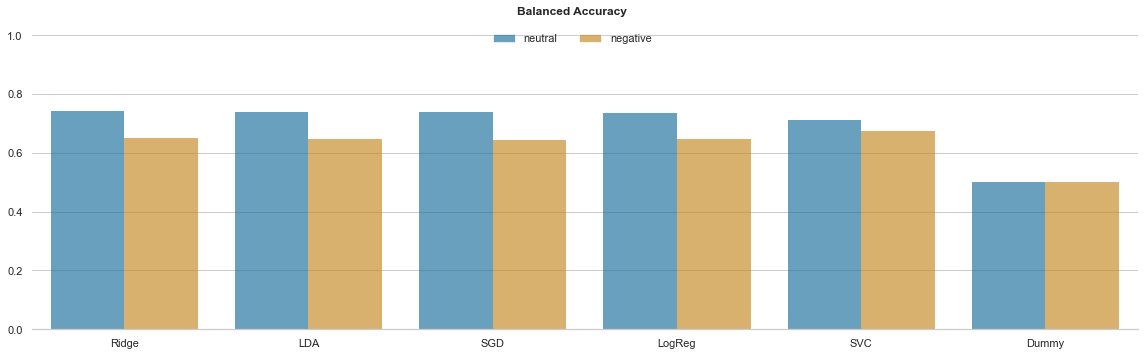

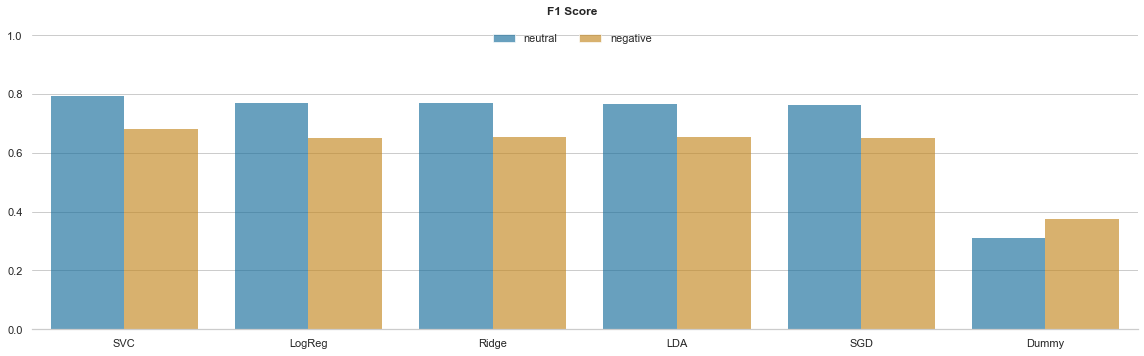

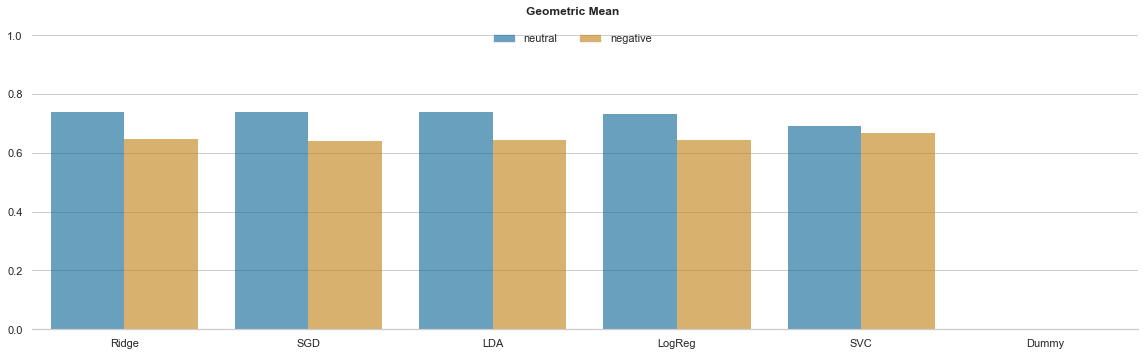

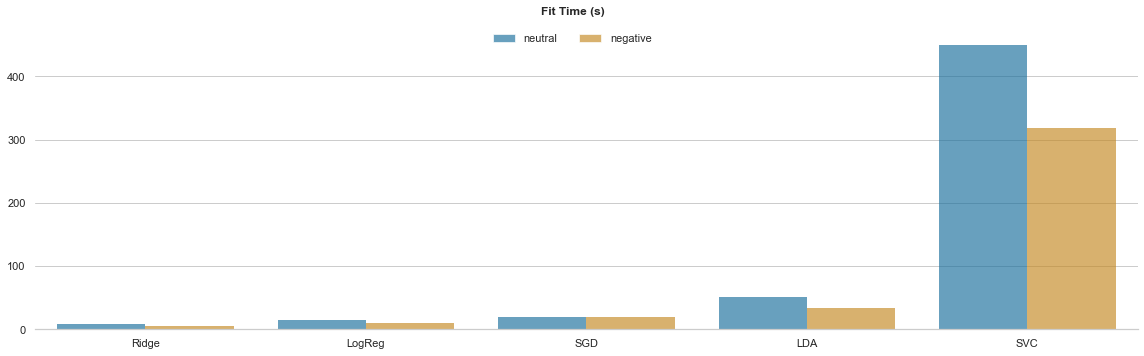

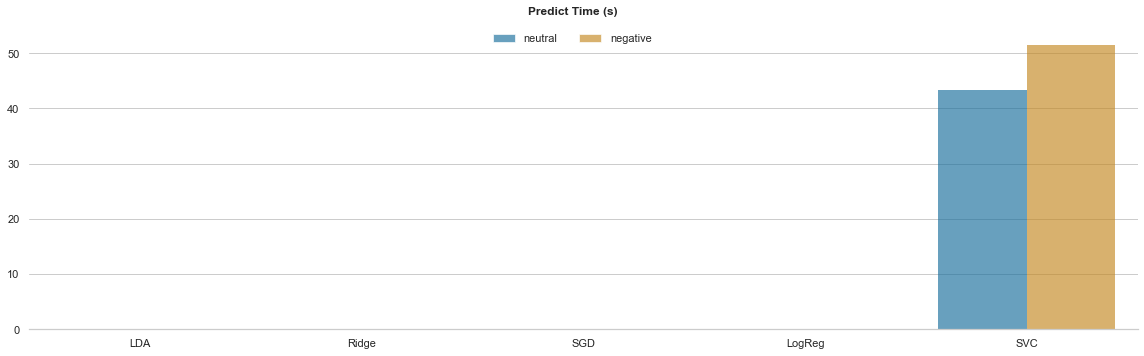

time: 2.1 s


In [18]:
for metric in tqdm(METRICS):
    plot_binary_metric(metric, results_df.loc[~results_df.case.str.contains("ternary")])

In [27]:
def plot_ternary_metric(metric: str, results_df: pd.DataFrame) -> None:
    """Draw a barplot by ternary classifier."""
    time_metric = "time" in metric
    results_df = results_df.sort_values(by=metric, ascending=time_metric)

    if time_metric:
        # When plotting fit/predict times, the pure dummy classifiers are omitted since it is always the fastest.
        results_df = results_df.loc[
            ~results_df.model_name.isin(("Dummy", "Dummy+Dummy"))
        ]

    g = sns.catplot(
        x=metric,
        y="model_name",
        data=results_df,
        seed=SEED,
        kind="bar",
        palette="colorblind",
        alpha=0.65,
    )
    g.fig.set_figwidth(10)
    g.fig.set_figheight(15)
    g.despine(**dict.fromkeys(("bottom", "left", "top", "right"), True))

    ax = plt.gca()
    ax.tick_params(axis="x", labelbottom=True, labeltop=True)
    plt.setp(ax.patches, linewidth=0)

    if not time_metric:
        plt.xlim(0, 1)
    plt.xlabel("")
    plt.ylabel("")

    plt.suptitle(
        f"{metric_names[metric]}{' (s)' if time_metric else ''}", y=1, fontweight="bold"
    )
    plt.tight_layout()
    plt.show()


_ = gc_collect()

time: 203 ms


  0%|          | 0/5 [00:00<?, ?it/s]

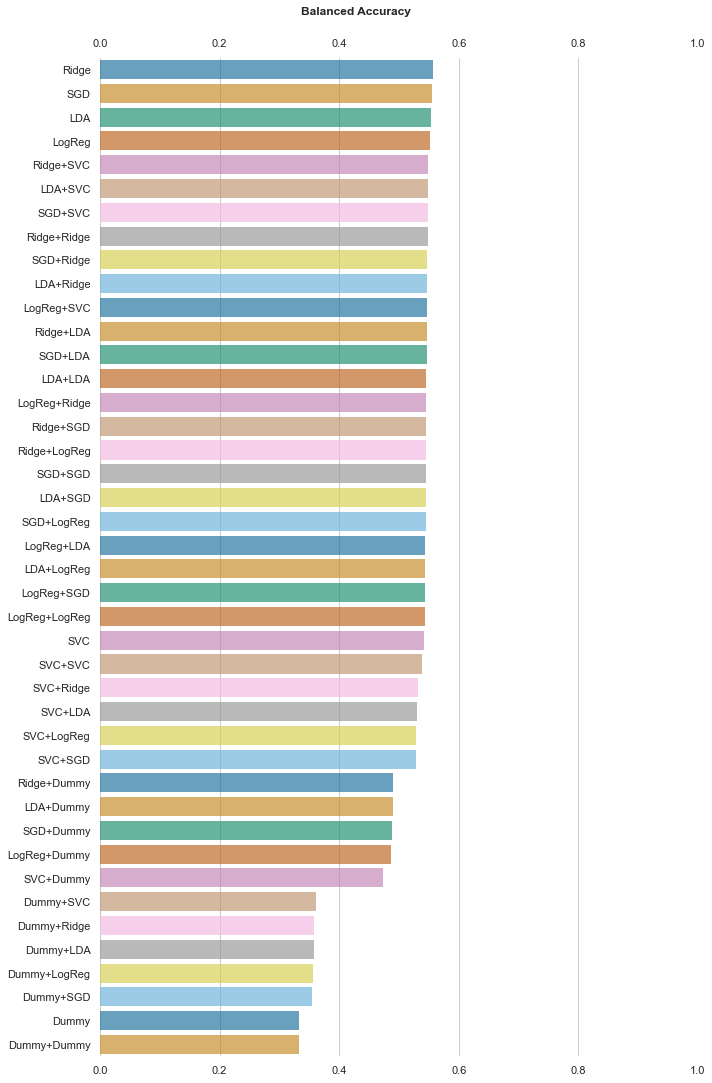

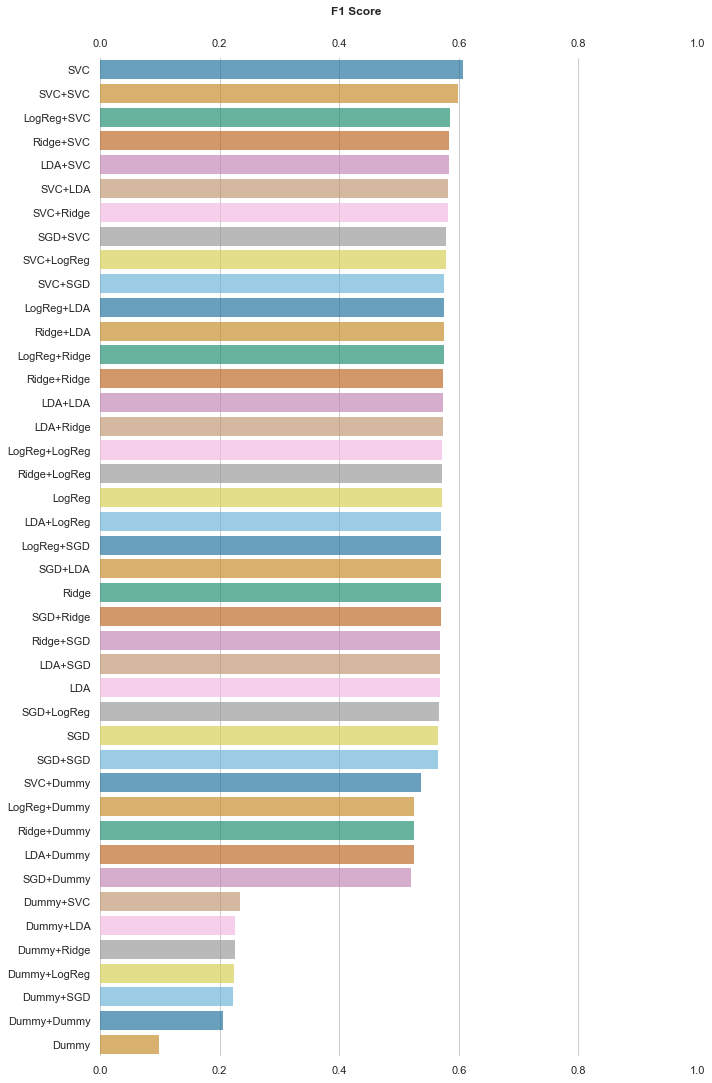

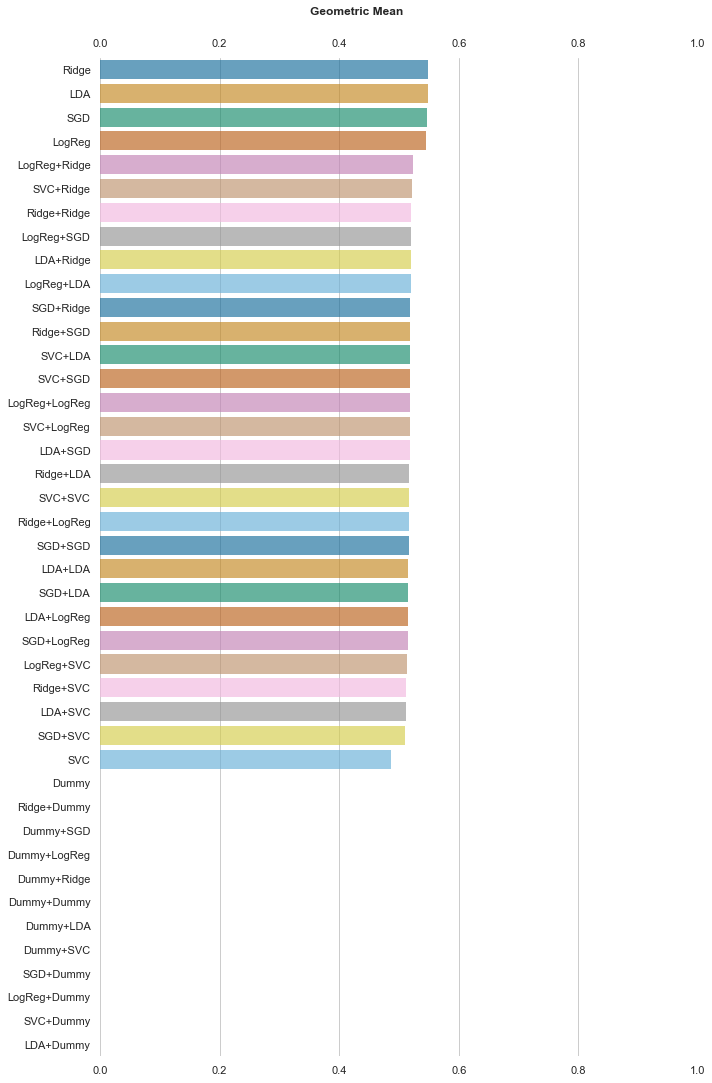

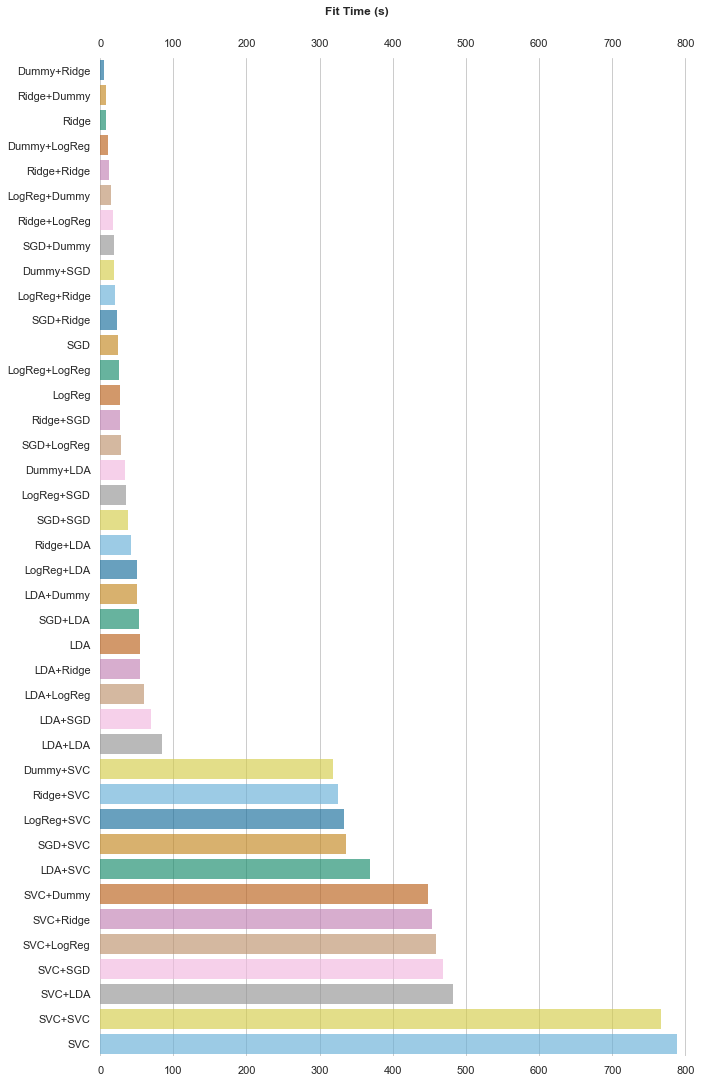

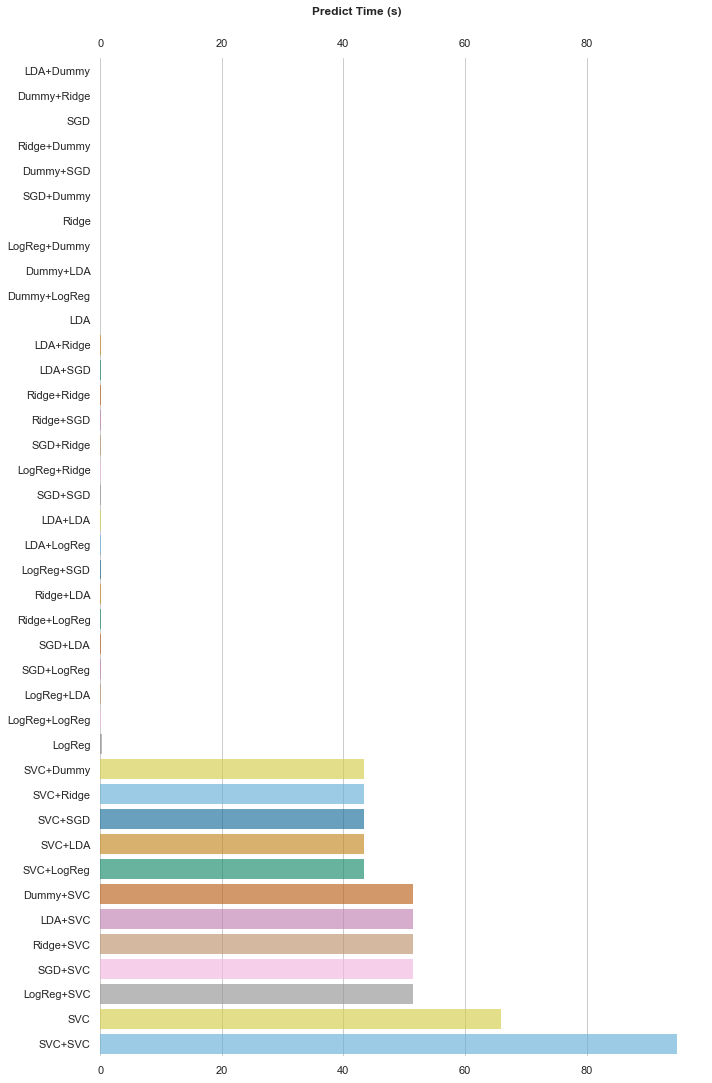

time: 4.6 s


In [28]:
for metric in tqdm(METRICS):
    plot_ternary_metric(metric, results_df.loc[results_df.case.str.contains("ternary")])

In [21]:
# save table of results
results_df.to_csv(f"{DATA_OUT_FOLDER}/untuned_full_results_CV5.csv")

time: 13.1 ms


# Discussion

The plots reveal that 

In [22]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 10322.748837471008 s
time: 144 ms


[^top](#Contents)